In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
sns.set_theme(style="whitegrid")
import itertools
import nibabel as nib
import numpy as np
# from varname import nameof
import pandas as pd
from nilearn.plotting import plot_glass_brain
import statsmodels.stats.multitest as multitest

In [4]:
sns.color_palette("husl", 14)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9386807511529497, 0.48901639250529133, 0.19623149776413562),
 (0.7757319041862729, 0.5784925270759935, 0.19475566538551875),
 (0.6566480096570136, 0.6229564921397143, 0.1938976562578914),
 (0.5105309046900421, 0.6614299289084904, 0.1930849118538962),
 (0.19468252393000074, 0.6998280342882891, 0.3041476695746048),
 (0.20433460114757862, 0.6863857739476534, 0.5407103379425205),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21662978923073606, 0.6676586160122123, 0.7318695594345369),
 (0.2266813382629933, 0.6508721810235698, 0.85618939194681),
 (0.5049017849530067, 0.5909119231215284, 0.9584657252128558),
 (0.7563369715809057, 0.5008642633638004, 0.9580503362615219),
 (0.9587050080494405, 0.36622595657917456, 0.9231469575614251),
 (0.9640248692994725, 0.41206779951067346, 0.7303540600728443)]

In [5]:
def create_img_for_glassbrain_plot(stat_to_plot, atlas_path, n_roi):
    # load parcellation
    atlas_img = nib.load(atlas_path)
    atlas_data = atlas_img.get_fdata()

    # init new image to plot
    new_img = np.zeros(atlas_data.shape)

    # check if dimensions match between input data and parcellation
    stat_to_plot = np.reshape(stat_to_plot,[n_roi,1])
    a_roi = int(np.max(atlas_data))
    if n_roi != a_roi:
        print("dimension not match, please check the input data or atlas")
    print("max roi label: ", np.max(atlas_data))

    # assign value to each ROI
    for roi in range(0,n_roi,1):
            itemindex = np.where(atlas_data==roi+1) # find voxels in this node (add 1 to account for zero-indexing)
            new_img[itemindex] = stat_to_plot[roi] # color them by the desired value 

    # affine new image to atlas image
    affine = atlas_img.affine
    img_nii = nib.Nifti1Image(new_img, affine)

    return img_nii

In [6]:
df_movies = pd.read_csv('../../data/HCP/df_movie_lengths_cleaned.csv')
#df_movies.sort_values(by='duration')
movienames = ['two_men','bridgeville','pockets','inception','social_net', 'oceans_11', 'flower', 'hotel', 'garden', 'dreary', 'home_alone', 'brokovich', 'star_wars']
df_movies

,session,movie_num,movie_name,duration,start,end
0,1,1,two men,234,31,264
1,1,2,bridgeville,211,295,505
2,1,3,pockets,179,536,714
3,1,4,overcome,53,745,797
4,2,1,inception,217,31,247
5,2,2,social net,249,277,525
6,2,3,ocean's 11,239,556,794
7,3,1,flower,170,31,200
8,3,2,hotel,174,231,404
9,3,3,garden,195,435,629


### check variance data

# load acc, var data

In [7]:
df_132 = pd.read_csv('var_13clips_132tr.csv')
df_acc_sex = pd.read_csv('acc_sex_pc2_ridge_thre0.csv')
df_acc_pmat = pd.read_csv('acc_pmat_pc1_ridge_thre0.csv')
acc_sex = df_acc_sex.balanced_accuracy.values*100
acc_pmat = df_acc_pmat.pearson.values
var = df_132.mean(axis=0).values*100

In [8]:
df_acc_pmat

,movieid,movie,pearson,spearman,r2
0,0,two_men,0.011119,0.036873,-0.629999
1,1,bridgeville,0.212858,0.190702,-0.293950
2,2,pockets,0.296376,0.274203,-0.181334
3,4,inception,0.231768,0.223505,-0.214449
4,5,social_net,0.194038,0.176719,-0.263984
5,6,oceans_11,0.180324,0.184677,-0.286034
6,7,flower,0.030470,0.011364,-0.494020
7,8,hotel,-0.113859,-0.099627,-0.792014
8,9,garden,0.038504,0.042940,-0.486605
9,10,dreary,-0.060843,-0.071790,-0.544502


In [9]:
var_all = df_132.values
var_all.shape

(436, 13)

In [10]:
# Melt the DataFrame to convert it to long format
melted_df = df_132.melt(var_name='Group', value_name='Value')
melted_df

,Group,Value
0,two_men,0.224468
1,two_men,0.275920
2,two_men,0.219470
3,two_men,0.191838
4,two_men,0.287413
...,...,...
5663,star_wars,0.055611
5664,star_wars,0.059006
5665,star_wars,0.051731
5666,star_wars,0.051588


In [134]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from scipy.stats import f_oneway

# Assuming your data array is named 'data'

# Transpose the data array
transposed_data = var_all.T

# Perform ANOVA
f_statistic, p_value = f_oneway(*transposed_data)

print(f"F-statistic = {f_statistic}, p-value = {p_value}")


# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(melted_df['Value'], melted_df['Group'])

print(tukey_results)

F-statistic = 33.40496746583136, p-value = 1.5713045138756182e-75
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1     group2   meandiff p-adj   lower   upper  reject
-------------------------------------------------------------
bridgeville  brokovich   0.0346    0.0  0.0118  0.0575   True
bridgeville     dreary  -0.0478    0.0 -0.0707  -0.025   True
bridgeville     flower    0.016 0.5007 -0.0068  0.0388  False
bridgeville     garden   0.0415    0.0  0.0187  0.0644   True
bridgeville home_alone   0.0227 0.0525 -0.0001  0.0456  False
bridgeville      hotel   0.0342 0.0001  0.0114  0.0571   True
bridgeville  inception   0.0714    0.0  0.0486  0.0943   True
bridgeville  oceans_11   0.0206 0.1256 -0.0022  0.0435  False
bridgeville    pockets   0.0076 0.9968 -0.0152  0.0304  False
bridgeville social_net   0.0268 0.0066   0.004  0.0497   True
bridgeville  star_wars   0.0474    0.0  0.0245  0.0702   True
bridgeville    two_men   0.0346    0.0  0.0117  0.0574   True
  br

# ROI/network info

In [17]:
df_rr =pd.read_csv('./corr_iss_acc_sex_without_dreary.csv')
netname = np.load('Schaefer436_netlabels.npy')
netind = np.load('Schaefer436_netind.npy')
roiname = np.load('Schaefer436_roilabels.npy')
netnames7 = np.load('Schaefer436_netlabel_7nets.npy')

# Compute model fit

## Sex without dreary

In [45]:
movienames = ['two_men','bridgeville','pockets','inception','social_net', 'oceans_11', 'flower', 'hotel', 'garden', 'home_alone', 'brokovich', 'star_wars']
acc_sex = df_acc_sex[df_acc_sex.movie.isin(movienames)].balanced_accuracy.values*100
var_all = df_132[movienames].values*100
var = df_132[movienames].mean(axis=0).values*100
print('var shape:', var.shape, 'acc_shape:',acc_sex.shape)

var shape: (12,) acc_shape: (12,)


### linear

In [46]:
import numpy as np
import statsmodels.api as sm

# linear regression
X =  var_all #X 436*12; y 1*12
y = acc_sex
term_ind = 1 # first order term index

r2_reg = []
coef_reg = []
aic_reg = []
bic_reg = []
pval_reg = []

# Z-score normalize y
y = (y - np.mean(y)) / np.std(y)


# Iterate over each row in X
for i in range(X.shape[0]):
    # Get the features and target for the current row
    X_row = X[i].reshape(-1, 1)  # Reshape to maintain 2D array
    y_row = y.reshape(-1, 1)  # Reshape to maintain 2D array

    # Z-score normalize 
    y_row = (y_row - np.mean(y_row)) / np.std(y_row)
    X_row = (X_row - np.mean(X_row)) / np.std(X_row)
    
    # add intercept
    X_row = sm.add_constant(X_row)

    # Fit the regression model
    model_reg = sm.OLS(y_row, X_row).fit()

    # Compute AIC, BIC and r2
    aic_temp = model_reg.aic
    bic_temp = model_reg.bic
    r2_temp = model_reg.rsquared
    coef_temp = model_reg.params[term_ind] # coefficient of the first order term

    coef_reg = coef_reg + [coef_temp]
    r2_reg = r2_reg + [r2_temp]
    aic_reg = aic_reg +[aic_temp]
    bic_reg = bic_reg + [bic_temp]

    # # pvalue - t test of coef
    # pvals = model_reg.t_test(np.eye(len(model_reg.params)))
    # pval_reg = pval_reg + [pvals.pvalue[term_ind]]

    # pvalue - full model
    pval_reg = pval_reg + [model_reg.f_pvalue]

max roi label:  436.0


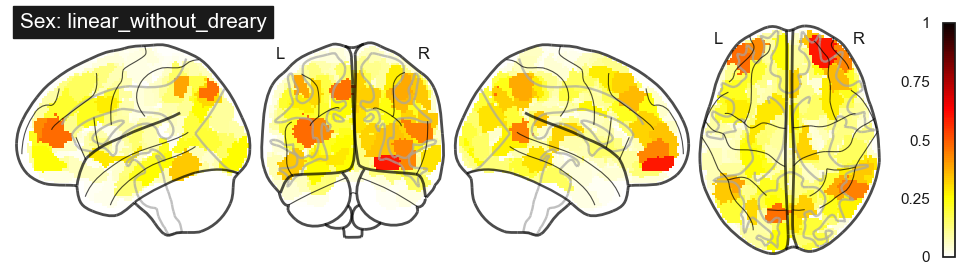

In [205]:
n_roi = 436
# only show p<0.05
r_sig = np.array(r2_reg)
#r_sig[np.array(P)>0.05] = 0
# fw_bin_sum = fw_bin.sum(axis=1)
# r_sig[fw_bin_sum<4]=0

stat_to_plot = r_sig

atlas_path = '/Users/xli/Desktop/xli_work/Toolbox/Susanne_Schaefer_436.nii'
img_nii = create_img_for_glassbrain_plot(stat_to_plot, atlas_path, n_roi)

fig = plot_glass_brain(img_nii, plot_abs=False,vmin=-1, vmax=1, colorbar=True, display_mode='lyrz') 
#plot_glass_brain(img_nii, plot_abs=False, vmin=-1, vmax=1, colorbar=True, display_mode='lyrz') 
fig.title('Sex: linear_without_dreary')
#fig.savefig('/Users/xli/Desktop/Github/TOPF_evaluation/figures/pearsonr_acc_pc1var_ntr132.jpg', dpi = 150)

### second order

In [47]:
import numpy as np
import statsmodels.api as sm

# linear regression
X =  var_all #X 436*12; y 1*12
y = acc_sex
term_ind = 2 # first order term index


r2_poly = []
coef_poly = []
aic_poly = []
bic_poly = []
pval_poly = []

# Iterate over each row in X
for i in range(X.shape[0]):
    # Get the features and target for the current row
    X_row = X[i].reshape(-1, 1)  # Reshape to maintain 2D array
    y_row = y.reshape(-1, 1)  # Reshape to maintain 2D array

    # Z-score normalize 
    y_row = (y_row - np.mean(y_row)) / np.std(y_row)
    X_row = (X_row - np.mean(X_row)) / np.std(X_row)
    
    # add intercept and squared term
    
    X_poly = np.column_stack((X_row, X_row**2))
    X_poly = sm.add_constant(X_poly)
    
    # Fit the regression model
    model_poly = sm.OLS(y_row, X_poly).fit()

    # Compute AIC, BIC and r2
    aic_temp = model_poly.aic
    bic_temp = model_poly.bic
    r2_temp = model_poly.rsquared
    coef_temp = model_poly.params[term_ind] # coefficient of the first order term

    coef_poly = coef_poly + [coef_temp]
    r2_poly = r2_poly + [r2_temp]
    aic_poly = aic_poly +[aic_temp]
    bic_poly = bic_poly + [bic_temp]

    # # pvalue - t test of coef
    # pvals = model_poly.t_test(np.eye(len(model_poly.params)))
    # pval_poly = pval_poly + [pvals.pvalue[term_ind]]

    # pvalue - full model
    pval_poly = pval_poly + [model_poly.f_pvalue]

In [48]:
model_poly.f_pvalue

0.33794328276114316

In [49]:
df_result = pd.DataFrame(data=r2_reg,columns=['r2_reg'])
df_result.insert(1,'bic_reg',bic_reg)
df_result.insert(2,'aic_reg',aic_reg)
df_result.insert(3,'coef_reg',coef_reg)
df_result.insert(4,'pval_reg', pval_reg)
df_result.insert(5,'r2_poly',r2_poly)
df_result.insert(6,'bic_poly',bic_poly)
df_result.insert(7,'aic_poly',aic_poly)
df_result.insert(8,'coef_poly',coef_poly)
df_result.insert(9,'pval_poly', pval_poly)
df_result.to_csv('model_fit_iss_acc_sex_without_dreary_2models_fullmodelpval_zscorexy.csv',index=False)

max roi label:  436.0


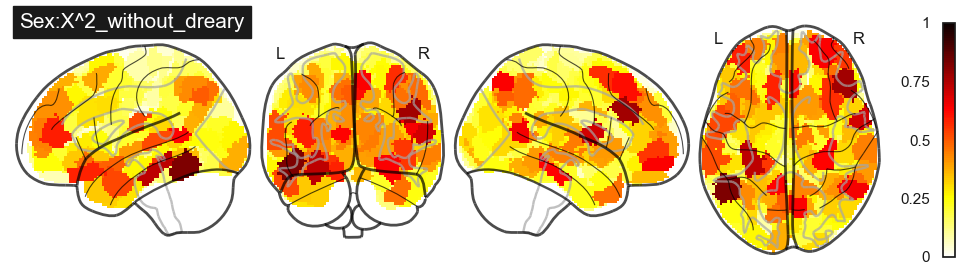

In [207]:
n_roi = 436
# only show p<0.05
r_sig = np.array(r2_poly)
#r_sig[np.array(P)>0.05] = 0
# fw_bin_sum = fw_bin.sum(axis=1)
# r_sig[fw_bin_sum<4]=0

stat_to_plot = r_sig

atlas_path = '/Users/xli/Desktop/xli_work/Toolbox/Susanne_Schaefer_436.nii'
img_nii = create_img_for_glassbrain_plot(stat_to_plot, atlas_path, n_roi)

fig = plot_glass_brain(img_nii, plot_abs=False,vmin=-1, vmax=1, colorbar=True, display_mode='lyrz') 
#plot_glass_brain(img_nii, plot_abs=False, vmin=-1, vmax=1, colorbar=True, display_mode='lyrz') 
fig.title('Sex:X^2_without_dreary')
#fig.savefig('/Users/xli/Desktop/Github/TOPF_evaluation/figures/pearsonr_acc_pc1var_ntr132.jpg', dpi = 150)


### Find best model

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1  0  0
 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
  0  0  0  0  0  0  1  0  0  1  0  0  0  0  1  0  0  0  0  0  0  1  0  0
  1  1  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0

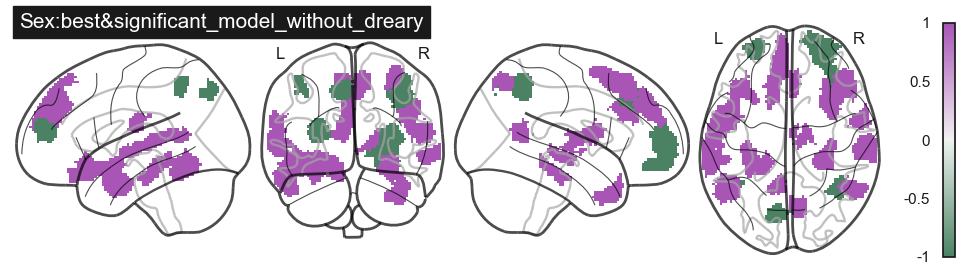

In [208]:
# lower bic or aic, better model
scores = [bic_reg, bic_poly]
scores = np.array(scores).T
model_ind = np.argmin(scores,axis=1)
model_ind[model_ind==0]=-1 # -1: linear model

# exclude non-significant ones
for i in range(0,len(model_ind)):
    if model_ind[i] == - 1:
        if pval_reg[i]>=0.05:
            model_ind[i]=0
    if model_ind[i] == 1:
        if pval_poly[i]>=0.05:
            model_ind[i]=0
print(model_ind)

# plot
cmap = sns.color_palette("vlag", as_cmap=True)
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

n_roi = 436
a = model_ind

stat_to_plot = a

atlas_path = '/Users/xli/Desktop/xli_work/Toolbox/Susanne_Schaefer_436.nii'
img_nii = create_img_for_glassbrain_plot(stat_to_plot, atlas_path, n_roi)

fig = plot_glass_brain(img_nii, plot_abs=False,vmin=-1, vmax=1, colorbar=True, display_mode='lyrz',cmap=cmap) 
#plot_glass_brain(img_nii, plot_abs=False, vmin=-1, vmax=1, colorbar=True, display_mode='lyrz') 
fig.title('Sex:best&significant_model_without_dreary')
#fig.savefig('/Users/xli/Desktop/Github/TOPF_evaluation/figures/pearsonr_acc_pc1var_ntr132.jpg', dpi = 150)


### plot signs of coef

max roi label:  436.0


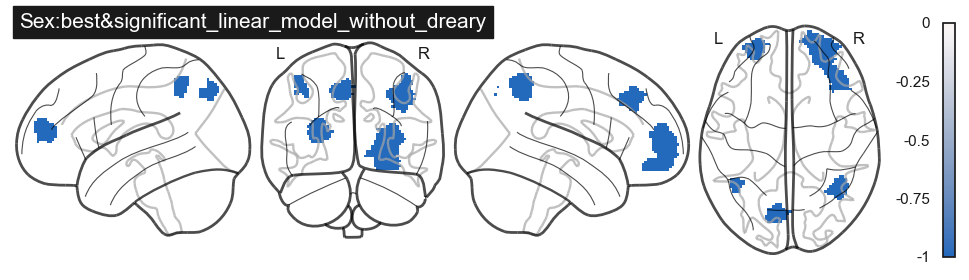

In [209]:
# plot
cmap = sns.color_palette("vlag", as_cmap=True)
#cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

n_roi = 436

coef_reg = np.array(coef_reg)
coef_reg[model_ind!=-1]=0
coef_reg[coef_reg>0] = 1
coef_reg[coef_reg<0] = -1
a = coef_reg

stat_to_plot = a

atlas_path = '/Users/xli/Desktop/xli_work/Toolbox/Susanne_Schaefer_436.nii'
img_nii = create_img_for_glassbrain_plot(stat_to_plot, atlas_path, n_roi)

fig = plot_glass_brain(img_nii, plot_abs=False,vmin=-1, vmax=1, colorbar=True, display_mode='lyrz',cmap=cmap) 
#plot_glass_brain(img_nii, plot_abs=False, vmin=-1, vmax=1, colorbar=True, display_mode='lyrz') 
fig.title('Sex:best&significant_linear_model_without_dreary')
#fig.savefig('/Users/xli/Desktop/Github/TOPF_evaluation/figures/pearsonr_acc_pc1var_ntr132.jpg', dpi = 150)

max roi label:  436.0


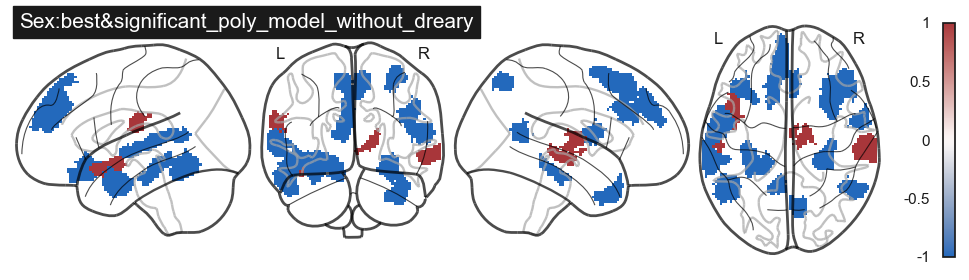

In [211]:
# plot
cmap = sns.color_palette("vlag", as_cmap=True)
#cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

n_roi = 436

coef_poly = np.array(coef_poly)
coef_poly[model_ind!=1]=0
coef_poly[coef_poly>0] = 1
coef_poly[coef_poly<0] = -1
a = coef_poly

stat_to_plot = a

atlas_path = '/Users/xli/Desktop/xli_work/Toolbox/Susanne_Schaefer_436.nii'
img_nii = create_img_for_glassbrain_plot(stat_to_plot, atlas_path, n_roi)

fig = plot_glass_brain(img_nii, plot_abs=False,vmin=-1, vmax=1, colorbar=True, display_mode='lyrz',cmap=cmap) 
#plot_glass_brain(img_nii, plot_abs=False, vmin=-1, vmax=1, colorbar=True, display_mode='lyrz') 
fig.title('Sex:best&significant_poly_model_without_dreary')
#fig.savefig('/Users/xli/Desktop/Github/TOPF_evaluation/figures/pearsonr_acc_pc1var_ntr132.jpg', dpi = 150)

## PMAT without dreary

In [66]:
movienames = ['two_men','bridgeville','pockets','inception','social_net', 'oceans_11', 'flower', 'hotel', 'garden', 'home_alone', 'brokovich', 'star_wars']
acc_pmat = df_acc_pmat[df_acc_pmat.movie.isin(movienames)].pearson.values
var = df_132[movienames].mean(axis=0).values*100
var_all = df_132[movienames].values*100
print('var shape:', var.shape, 'acc_shape:',acc_pmat.shape)

var shape: (12,) acc_shape: (12,)


### linear

In [67]:
import numpy as np
import statsmodels.api as sm

# linear regression
X =  var_all #X 436*13; y 1*13
y = acc_pmat
term_ind = 1 # first order term index

r2_reg = []
coef_reg = []
aic_reg = []
bic_reg = []
pval_reg = []

# Iterate over each row in X
for i in range(X.shape[0]):
    # Get the features and target for the current row
    X_row = X[i].reshape(-1, 1)  # Reshape to maintain 2D array
    y_row = y.reshape(-1, 1)  # Reshape to maintain 2D array

    # Z-score normalize 
    y_row = (y_row - np.mean(y_row)) / np.std(y_row)
    X_row = (X_row - np.mean(X_row)) / np.std(X_row)

    # add intercept
    X_row = sm.add_constant(X_row)

    # Fit the regression model
    model_reg = sm.OLS(y_row, X_row).fit()

    # Compute AIC, BIC and r2
    aic_temp = model_reg.aic
    bic_temp = model_reg.bic
    r2_temp = model_reg.rsquared
    coef_temp = model_reg.params[term_ind] # coefficient of the first order term

    coef_reg = coef_reg + [coef_temp]
    r2_reg = r2_reg + [r2_temp]
    aic_reg = aic_reg +[aic_temp]
    bic_reg = bic_reg + [bic_temp]

    # # pvalue - t test of coef
    # pvals = model_reg.t_test(np.eye(len(model_reg.params)))
    # pval_reg = pval_reg + [pvals.pvalue[term_ind]]

    # pvalue - full model
    pval_reg = pval_reg + [model_reg.f_pvalue]

max roi label:  436.0


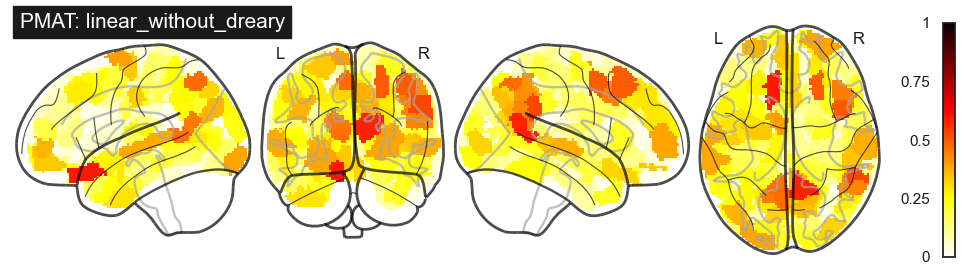

In [181]:
n_roi = 436

stat_to_plot = r2_reg

atlas_path = '/Users/xli/Desktop/xli_work/Toolbox/Susanne_Schaefer_436.nii'
img_nii = create_img_for_glassbrain_plot(stat_to_plot, atlas_path, n_roi)

fig = plot_glass_brain(img_nii, plot_abs=False,vmin=-1, vmax=1, colorbar=True, display_mode='lyrz') 
#plot_glass_brain(img_nii, plot_abs=False, vmin=-1, vmax=1, colorbar=True, display_mode='lyrz') 
fig.title('PMAT: linear_without_dreary')
#fig.savefig('/Users/xli/Desktop/Github/TOPF_evaluation/figures/pearsonr_acc_pc1var_ntr132.jpg', dpi = 150)

### 2nd-order

In [52]:
import numpy as np
import statsmodels.api as sm

# linear regression
X =  var_all #X 436*13; y 1*13
y = acc_pmat
term_ind = 2 # first order term index


r2_poly = []
coef_poly = []
aic_poly = []
bic_poly = []
pval_poly = []

# Iterate over each row in X
for i in range(X.shape[0]):
    # Get the features and target for the current row
    X_row = X[i].reshape(-1, 1)  # Reshape to maintain 2D array
    y_row = y.reshape(-1, 1)  # Reshape to maintain 2D array

    # Z-score normalize 
    y_row = (y_row - np.mean(y_row)) / np.std(y_row)
    X_row = (X_row - np.mean(X_row)) / np.std(X_row)

    # add intercept and squared term
    
    X_poly = np.column_stack((X_row, X_row**2))
    X_poly = sm.add_constant(X_poly)
    
    # Fit the regression model
    model_poly = sm.OLS(y_row, X_poly).fit()

    # Compute AIC, BIC and r2
    aic_temp = model_poly.aic
    bic_temp = model_poly.bic
    r2_temp = model_poly.rsquared
    coef_temp = model_poly.params[term_ind] # coefficient of the first order term

    coef_poly = coef_poly + [coef_temp]
    r2_poly = r2_poly + [r2_temp]
    aic_poly = aic_poly +[aic_temp]
    bic_poly = bic_poly + [bic_temp]

    # # pvalue - t test of coef
    # pvals = model_poly.t_test(np.eye(len(model_poly.params)))
    # pval_poly = pval_poly + [pvals.pvalue[term_ind]]

    # pvalue - full model
    pval_poly = pval_poly + [model_poly.f_pvalue]

In [53]:
df_result = pd.DataFrame(data=r2_reg,columns=['r2_reg'])
df_result.insert(1,'bic_reg',bic_reg)
df_result.insert(2,'aic_reg',aic_reg)
df_result.insert(3,'coef_reg',coef_reg)
df_result.insert(4,'pval_reg', pval_reg)
df_result.insert(5,'r2_poly',r2_poly)
df_result.insert(6,'bic_poly',bic_poly)
df_result.insert(7,'aic_poly',aic_poly)
df_result.insert(8,'coef_poly',coef_poly)
df_result.insert(9,'pval_poly', pval_poly)
df_result.to_csv('model_fit_iss_acc_pmat_without_dreary_2models_fullmodelpval_zscorexy.csv',index=False)